In [19]:
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import pandas as pd
from Pilsung import*
from Model.CNN import cnn_classifier
from utils.LoadData import load_CW_Source,load_CW_Target
from sklearn.utils import shuffle

In [20]:
def calculate_cumulative_accuracy(profiling_Data_path, Target_Data_path, model_path, model_name, p_attack_to_label_total):
    """Calculate cumulative classification accuracy across trace counts
    
    Args:
        profiling_Data_path (str): Path to profiling traces dataset
        Target_Data_path (str): Path to attack traces dataset
        model_path (str): Directory containing pre-trained model
        model_name (str): Filename of the pre-trained model
        p_attack_to_label_total (list): Ground truth label mapping
    
    Returns:
        list: Average accuracy values for each trace count
    """
    # Initialize data containers
    pk_v_box = np.zeros((256, 256))  # Stores intermediate key-byte mappings
    p_v_box = np.zeros(256)          # Final plaintext-to-label mappings
    acc = []                         # Accuracy storage
    
    # Iterate through different trace counts
    for trace_num in range(1000, 10001, 1000):
        run_acc = []  # Accuracy storage per trace count
        
        # Repeat experiment 20 times for statistical significance
        for _ in range(20):
            # Load and prepare datasets
            profiling_traces, _, _, _, _, _ = load_CW_Source(
                in_file=profiling_Data_path,
                sec=18000
        )
            X_attack, label_V, p_attack = load_CW_Target(
                in_file=Target_Data_path,
            )
            
            # Shuffle attack dataset
            X_attack, label_V, p_attack = shuffle(X_attack, label_V, p_attack)
            
            # Select subset of traces
            X_attack_shuffle = X_attack[:trace_num]
            p_attack_shuffle = p_attack[:trace_num]

            # Data preprocessing pipeline
            # 1. Standardization (z-score normalization)
            scaler = preprocessing.StandardScaler()
            profiling_traces = scaler.fit_transform(profiling_traces)
            X_attack_shuffle = scaler.transform(X_attack_shuffle)
            
            # 2. Range normalization [0,1]
            scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
            profiling_traces = scaler.fit_transform(profiling_traces)
            X_attack_shuffle = scaler.transform(X_attack_shuffle)

            # Load pre-trained model
            model = cnn_classifier(input_size=600)
            model.load_weights(model_path + model_name)
            
            # Generate predictions
            predictions = model.predict(X_attack_shuffle)

            # Process model outputs
            A = np.squeeze(predictions)  # Predictions
            B = np.squeeze(p_attack_shuffle)     # Plaintext
            df = pd.DataFrame({'traces': list(A), 'plaintext': list(B)})
            
            # Aggregate predictions by plaintext
            sum_by_plaintext = df.groupby('plaintext')['traces'].sum()

            # Update mapping matrix
            for j in range(256):
                if j in sum_by_plaintext:
                    p_v_box[j] = np.argmax(sum_by_plaintext[j])
                else:
                    p_v_box[j] = -1  # Flag for missing values

            # Calculate accuracy
            total_num = acc_num = 0.0
            for p in range(256):
                if p_v_box[p] == -1:
                    continue
                if p_v_box[p] == p_attack_to_label_total[0][p]:
                    acc_num += 1
                total_num += 1
                
            run_acc.append(acc_num / total_num if total_num > 0 else 0.0)

        # Store average accuracy for current trace count
        acc.append(np.mean(run_acc))
        print(f"Traces: {trace_num}, Accuracy: {acc[-1]:.4f}")

    return acc

<b>Source Model-Target(rk1=0x2b)

In [21]:
# Main parameter initialization
profiling_Data_path='./Dataset/rk1=0x35/'
Target_Data_path = './Dataset/rk1=0x2b/'  # Path to target device traces
model_path = './Model/'  # Pre-trained model directory
model_name = 'Source_Model(RK1=0x35).h5'  # Model filename
result_path='./result/'

In [22]:

X_attack, label_V, p_attack = load_CW_Target(
            in_file=Target_Data_path)
p_attack_to_label_total=[]
p_attack_to_label_total.append({p: np.unique(label_V[p_attack == p]) for p in range(256)})


In [23]:
CA_rk1_0x2b=calculate_cumulative_accuracy(profiling_Data_path, Target_Data_path, model_path, model_name, p_attack_to_label_total)

Traces: 1000, Accuracy: 0.8616
Traces: 2000, Accuracy: 0.9014
Traces: 3000, Accuracy: 0.9164
Traces: 4000, Accuracy: 0.9244
Traces: 5000, Accuracy: 0.9285
Traces: 6000, Accuracy: 0.9277
Traces: 7000, Accuracy: 0.9324
Traces: 8000, Accuracy: 0.9326
Traces: 9000, Accuracy: 0.9344
Traces: 10000, Accuracy: 0.9336


<b>Source Model-Target(rk1=0xce)

In [24]:
# Main parameter initialization
profiling_Data_path='./Dataset/rk1=0x35/'
Target_Data_path = './Dataset/rk1=0xce/'  # Path to target device traces
model_path = './Model/'  # Pre-trained model directory
model_name = 'Source_Model(RK1).h5'  # Model filename
result_path='./result/'

In [25]:
X_attack, label_V, p_attack = load_CW_Target(
            in_file=Target_Data_path)
p_attack_to_label_total=[]
p_attack_to_label_total.append({p: np.unique(label_V[p_attack[:] == p]) for p in range(256)})

In [26]:
CA_rk1_0xce=calculate_cumulative_accuracy(profiling_Data_path, Target_Data_path, model_path, model_name, p_attack_to_label_total)

Traces: 1000, Accuracy: 0.8630
Traces: 2000, Accuracy: 0.9101
Traces: 3000, Accuracy: 0.9295
Traces: 4000, Accuracy: 0.9336
Traces: 5000, Accuracy: 0.9355
Traces: 6000, Accuracy: 0.9430
Traces: 7000, Accuracy: 0.9396
Traces: 8000, Accuracy: 0.9420
Traces: 9000, Accuracy: 0.9432
Traces: 10000, Accuracy: 0.9447


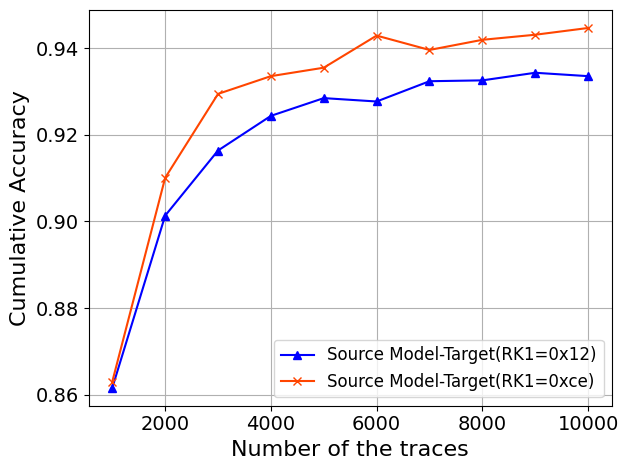

In [27]:
x = np.arange(1000, 10001, 1000)
plt.plot(x, CA_rk1_0x2b[:],color='b', marker='^',label='Source Model-Target(RK1=0x12)')
plt.plot(x, CA_rk1_0xce[:],color='orangered',marker='x',label='Source Model-Target(RK1=0xce)')
plt.grid(True)  

plt.xlabel('Number of the traces', fontsize=16)
plt.ylabel('Cumulative Accuracy', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('Pilsung_NCA.pdf')
plt.show()